# Determination of a prospective tariff for a telecom company

There is a federal cellular operator that offers its customers two tariff plans: Smart and Ultra.
To adjust the advertising budget, we need to find out which tariff brings more money.
It is necessary to conduct a preliminary analysis of tariffs on a small sample of customers from 500 users. There is data on who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and draw a conclusion - which tariff is better.

## Loading and preparing data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from scipy import stats as st
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
calls = pd.read_csv('/content/calls.csv')
internet = pd.read_csv('/content/internet.csv')
messages = pd.read_csv('/content/messages.csv')
tariffs = pd.read_csv('/content/tariffs.csv')
users = pd.read_csv('/content/users.csv')

In [ ]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [ ]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [ ]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [ ]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Since the analysis is carried out by months, for convenience, we will discard days in the date columns in all tables:

In [ ]:
users[~users['churn_date'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart


In [ ]:
users['reg_date'] = users['reg_date'].apply(lambda x: x[:7])
users['churn_date'] = users[~users['churn_date'].isna()]['churn_date'].apply(lambda x: x[:7])
internet['session_date'] = internet['session_date'].apply(lambda x: x[:7])
calls['call_date'] = calls['call_date'].apply(lambda x: x[:7])
messages['message_date'] = messages['message_date'].apply(lambda x: x[:7])

According to the task, each call is rounded up to the whole minute.

In [ ]:
calls['duration'] = np.ceil(calls['duration'])

In [ ]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07,0.00,1000
1,1000_1,2018-08,0.00,1000
2,1000_2,2018-06,3.00,1000
3,1000_3,2018-09,14.00,1000
4,1000_4,2018-12,6.00,1000


In [ ]:
[users.duplicated().sum(), calls.duplicated().sum(), messages.duplicated().sum(), internet.duplicated().sum()]

[0, 0, 0, 0]

In [ ]:
users.groupby('tariff')['churn_date'].value_counts()

tariff  churn_date
smart   2018-12       10
        2018-11        6
        2018-10        5
        2018-08        1
        2018-09        1
ultra   2018-12        6
        2018-10        4
        2018-09        2
        2018-11        2
        2018-08        1
Name: churn_date, dtype: int64

The data was loaded, checked, converted into the format necessary for further research.

## Calculation of the required parameters

For further analysis, it is necessary to collect a table that will contain the following data: subscriber ID, month, total number of minutes, number of calls, messages, traffic volume and monthly revenue, as well as tariff, subscriber location region.

Let's calculate for each user:

* 	number of calls made and spent minutes of calls by month:

In [ ]:
calls_data = calls.groupby(['user_id', 'call_date'])['duration'].agg(['sum','count']).reset_index()
calls_data.columns = ['user_id', 'month', 'calls_sum_length', 'calls_count']
calls_data

,user_id,month,calls_sum_length,calls_count
0,1000,2018-05,159.00,22
1,1000,2018-06,172.00,43
2,1000,2018-07,340.00,47
3,1000,2018-08,408.00,52
4,1000,2018-09,466.00,58
...,...,...,...,...
3169,1498,2018-10,247.00,41
3170,1499,2018-09,70.00,9
3171,1499,2018-10,449.00,68
3172,1499,2018-11,612.00,74


* number of sent messages by month:

In [ ]:
messages_data = messages.groupby(['user_id', 'message_date'], as_index=False).count()
messages_data.columns = ['user_id', 'month', 'messages_count']
messages_data

,user_id,month,messages_count
0,1000,2018-05,22
1,1000,2018-06,60
2,1000,2018-07,75
3,1000,2018-08,81
4,1000,2018-09,57
...,...,...,...
2712,1498,2018-10,42
2713,1499,2018-09,11
2714,1499,2018-10,48
2715,1499,2018-11,59


* the amount of Internet traffic used by months:

In [ ]:
internet_data = internet.groupby(['user_id', 'session_date'], as_index=False).mb_used.sum()
internet_data.columns = ['user_id', 'month', 'mb_used']
internet_data

,user_id,month,mb_used
0,1000,2018-05,2253.49
1,1000,2018-06,23233.77
2,1000,2018-07,14003.64
3,1000,2018-08,14055.93
4,1000,2018-09,14568.91
...,...,...,...
3198,1498,2018-10,20579.36
3199,1499,2018-09,1845.75
3200,1499,2018-10,17788.51
3201,1499,2018-11,17963.31


* let's collect the data in one dataframe, add information about the tariff and the region of residence:

In [ ]:
data = calls_data.merge(messages_data, on=['user_id', 'month'], how='outer')

In [ ]:
data = data.merge(internet_data, on=['user_id', 'month'], how='outer')

In [ ]:
data['tariff'] = data['user_id'].map(users.set_index('user_id')['tariff'])

In [ ]:
data['city'] = data['user_id'].map(users.set_index('user_id')['city'])

The lengths of the added dataframes are different, missing values appeared in the combined dataframe - this means that some users did not use this type of communication in some periods of time, for example, they did not send SMS. These gaps can be replaced with null values.

In [ ]:
data = data.fillna(0)

* calculate the monthly revenue from each user using the function:

In [ ]:
def revenue(data):
    """The function of calculating the revenue from the user, depending on the 
    connected tariff, the value of consumed minutes and gigabytes, according to 
    the tariff, are rounded up to the nearest integer"""
    if data['tariff'] == 'smart':
        if data['calls_sum_length'] > tariffs['minutes_included'][0]:
            calls_over = ceil(data['calls_sum_length'] - tariffs['minutes_included'][0]
                             )*tariffs['rub_per_minute'][0]
        else: calls_over = 0
        if data['messages_count'] > tariffs['messages_included'][0]:
            messages_over = ceil(data['messages_count'] - tariffs['messages_included'][0]
                                )*tariffs['rub_per_message'][0]
        else: messages_over = 0
        if data['mb_used'] > tariffs['mb_per_month_included'][0]:
            internet_over = ceil((data['mb_used'] - tariffs['mb_per_month_included'][0])/1024
                                )*tariffs['rub_per_gb'][0]
        else: internet_over = 0
        return (calls_over + messages_over + internet_over + tariffs['rub_monthly_fee'][0])
    else:
        if data['calls_sum_length'] > tariffs['minutes_included'][1]:
            calls_over = ceil(data['calls_sum_length'] - tariffs['minutes_included'][1]
                             )*tariffs['rub_per_minute'][1]
        else: calls_over = 0
        if data['messages_count'] > tariffs['messages_included'][1]:
            messages_over = ceil(data['messages_count'] - tariffs['messages_included'][1]
                                )*tariffs['rub_per_message'][1]
        else: messages_over = 0
        if data['mb_used'] > tariffs['mb_per_month_included'][1]:
            internet_over = ceil((data['mb_used'] - tariffs['mb_per_month_included'][1])/1024
                                )*tariffs['rub_per_gb'][1]
        else: internet_over = 0
        return (calls_over + messages_over + internet_over + tariffs['rub_monthly_fee'][1])

In [ ]:
ceil(data['calls_sum_length'][150] - tariffs['minutes_included'][0])

615

In [ ]:
data['revenue'] = data.apply(revenue, axis=1)
data

,user_id,month,calls_sum_length,calls_count,messages_count,mb_used,tariff,city,revenue
0,1000,2018-05,159.00,22.00,22.00,2253.49,ultra,Краснодар,1950
1,1000,2018-06,172.00,43.00,60.00,23233.77,ultra,Краснодар,1950
2,1000,2018-07,340.00,47.00,75.00,14003.64,ultra,Краснодар,1950
3,1000,2018-08,408.00,52.00,81.00,14055.93,ultra,Краснодар,1950
4,1000,2018-09,466.00,58.00,57.00,14568.91,ultra,Краснодар,1950
...,...,...,...,...,...,...,...,...,...
3209,1489,2018-09,0.00,0.00,32.00,17206.30,smart,Санкт-Петербург,950
3210,1489,2018-10,0.00,0.00,21.00,19559.44,smart,Санкт-Петербург,1550
3211,1489,2018-11,0.00,0.00,20.00,17491.56,smart,Санкт-Петербург,1150
3212,1489,2018-12,0.00,0.00,35.00,17322.51,smart,Санкт-Петербург,950


## Analysis of customer behavior

### Calculation of the mean, variance and standard deviation of the studied parameters

Let's determine how many minutes of conversation, how many messages and how much Internet traffic is required by users of each tariff per month. Let's create summary tables of average monthly consumption of services by users for each tariff:

In [ ]:
users_smart = data.query('tariff == "smart"').groupby('user_id', as_index=False).mean()
users_ultra = data.query('tariff == "ultra"').groupby('user_id', as_index=False).mean()
users_smart.head()

,user_id,calls_sum_length,calls_count,messages_count,mb_used,revenue
0,1001,422.00,61.00,0.00,16233.00,850.00
1,1002,216.71,31.00,10.00,16576.65,1035.71
2,1005,550.42,74.00,46.00,8307.28,827.00
3,1006,318.27,46.00,0.00,14926.26,931.82
4,1007,486.56,68.00,25.00,14625.07,913.44


In [ ]:
users_ultra.head()

,user_id,calls_sum_length,calls_count,messages_count,mb_used,revenue
0,1000,320.75,46.00,62.00,13424.04,1950.00
1,1003,764.40,104.00,76.00,11456.13,1950.00
2,1004,123.38,22.00,149.00,18629.94,1950.00
3,1013,468.00,71.00,21.00,15258.58,1950.00
4,1016,61.00,10.00,71.00,13405.22,1950.00


There are 350 subscribers of the "Smart" tariff and 148 subscribers of the "Ultra" tariff in the sample.

The sum of the rows in both pivot tables is less than the number of entries in the users list. Let's look for the missing users and check if they showed any activity:

In [ ]:
users.query('user_id not in @data.user_id').user_id

128    1128
371    1371
Name: user_id, dtype: int64

In [ ]:
calls.query('user_id == [1128,1371]').user_id.count()

0

In [ ]:
messages.query('user_id == [1128,1371]').user_id.count()

0

In [ ]:
internet.query('user_id == [1128,1371]').user_id.count()

0

It turns out that the two missing users were not active during the period under consideration.

Let's calculate the mean, variance and standard deviation for the studied parameters in both samples:

Tariff "Smart":

In [ ]:
smart_stat = users_smart[['calls_sum_length', 'messages_count', 'mb_used']].mean().to_frame(name='mean')
smart_stat['std'] = np.std(users_smart[['calls_sum_length', 'messages_count', 'mb_used']])
smart_stat['var'] = np.var(users_smart[['calls_sum_length', 'messages_count', 'mb_used']])
smart_stat

,mean,std,var
calls_sum_length,419.63,144.82,20974.05
messages_count,32.35,26.47,700.90
mb_used,16180.61,3574.10,12774223.26


Tariff "Ultra":

In [ ]:
ultra_stat = users_ultra[['calls_sum_length', 'messages_count', 'mb_used']].mean().to_frame(name='mean')
ultra_stat['std'] = np.std(users_ultra[['calls_sum_length', 'messages_count', 'mb_used']])
ultra_stat['var'] = np.var(users_ultra[['calls_sum_length', 'messages_count', 'mb_used']])
ultra_stat

,mean,std,var
calls_sum_length,527.82,280.83,78867.04
messages_count,54.03,46.21,2135.30
mb_used,19574.64,8283.06,68609020.18


In [ ]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


The average values of calls and messages for both tariffs are less than the number of services included in the package. The average volume of traffic slightly exceeds the available amount for the "Smart" tariff, and significantly falls short of it in the "Ultra" tariff.

### Drawing of parameter distribution histograms

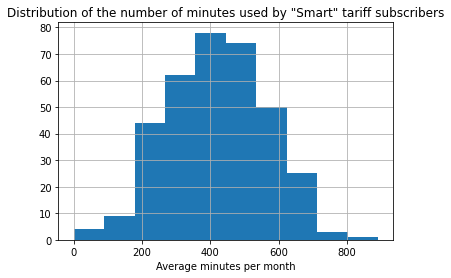

In [ ]:
plt.title('Distribution of the number of minutes used by "Smart" tariff subscribers')
plt.xlabel('Average minutes per month')
users_smart['calls_sum_length'].hist()
plt.show()

The distribution of the number of minutes used by "Smart" tariff subscribers is a normal distribution with the parameters calculated earlier: mean - 419.63, standard deviation - 144.82. The number of minutes included in the subscription fee is 500.

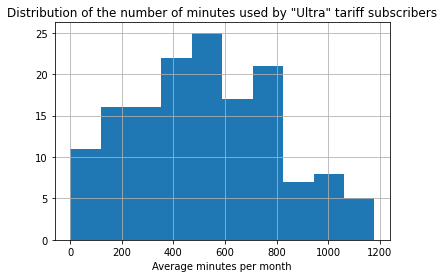

In [ ]:
plt.title('Distribution of the number of minutes used by "Ultra" tariff subscribers')
plt.xlabel('Average minutes per month')
users_ultra['calls_sum_length'].hist()
plt.show()

The distribution of the number of minutes used by subscribers of the "Ultra" tariff looks like a normal one with an average value of 527.82, but, in comparison with the previous one, its spread is much higher - 280.83. Affects a smaller number of subscribers of the tariff "Ultra". The number of minutes included in the subscription fee is 3000.

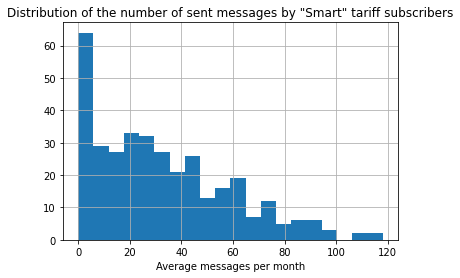

In [ ]:
plt.title('Distribution of the number of sent messages by "Smart" tariff subscribers')
plt.xlabel('Average messages per month')
users_smart['messages_count'].hist(bins=20)
plt.show()

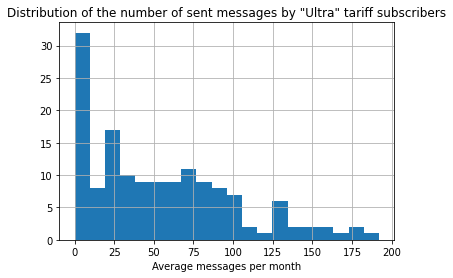

In [ ]:
plt.title('Distribution of the number of sent messages by "Ultra" tariff subscribers')
plt.xlabel('Average messages per month')
users_ultra['messages_count'].hist(bins=20)
plt.show()

In terms of messages sent, both samples show similar distributions with a peak of less than 10 messages per month and a heavy tail. This is not surprising, since recently, users are increasingly using instant messengers for communication. The number of messages included in the monthly fee is 50 and 1000 respectively.

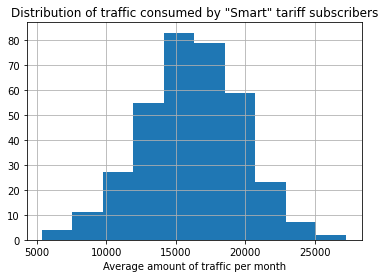

In [ ]:
plt.title('Distribution of traffic consumed by "Smart" tariff subscribers')
plt.xlabel('Average amount of traffic per month')
users_smart['mb_used'].hist()
plt.show()

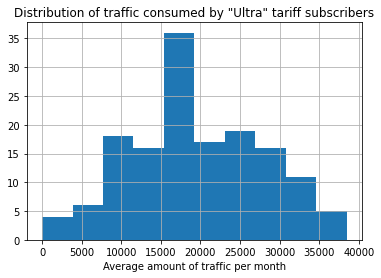

In [ ]:
plt.title('Distribution of traffic consumed by "Ultra" tariff subscribers')
plt.xlabel('Average amount of traffic per month')
users_ultra['mb_used'].hist()
plt.show()

As in the case of calls, traffic consumption distributions are symmetrical with respect to the average value, which is relatively close for subscribers of both tariffs. At the same time, most of the users of the "Ultra" tariff do not use the amount of traffic available to them (30720 Mb), and about half of the users of the "Smart" tariff exceed the limit of their package, equal to 15360 Mb.

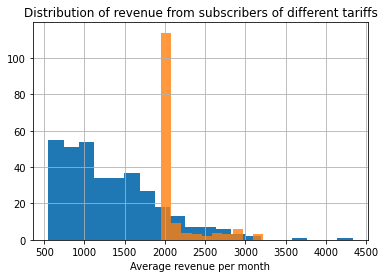

In [ ]:
plt.title('Distribution of revenue from subscribers of different tariffs')
plt.xlabel('Average revenue per month')
users_smart['revenue'].hist(bins=20)
users_ultra['revenue'].hist(alpha=0.8)
plt.show()

As a result of the analysis of customer behavior, we can conclude that the majority of Smart tariff users regularly exceed the limits on the number of used minutes and gigabytes included in the subscription fee of their tariff, while Ultra tariff subscribers, on the contrary, do not use prepaid services in full.

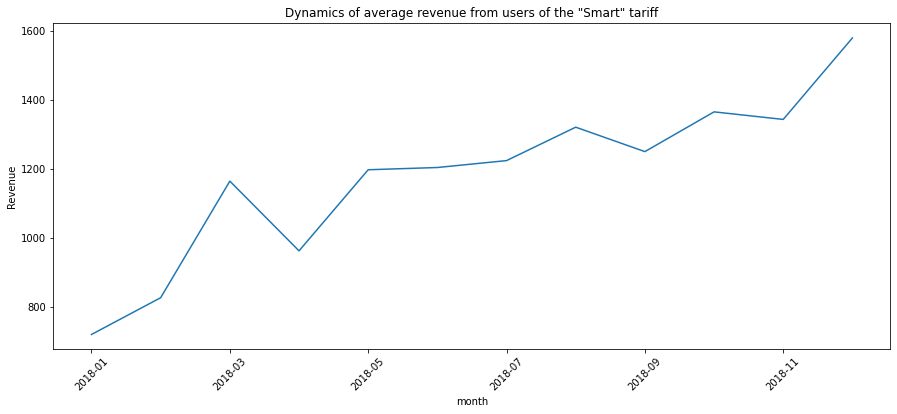

In [ ]:
plt.title('Dynamics of average revenue from users of the "Smart" tariff')
plt.ylabel('Revenue')
data.query('tariff == "smart"'
).groupby('month'
)['revenue'].agg('mean'
).plot(x='month', y='revenue', figsize=(15,6), rot=45)
plt.show()

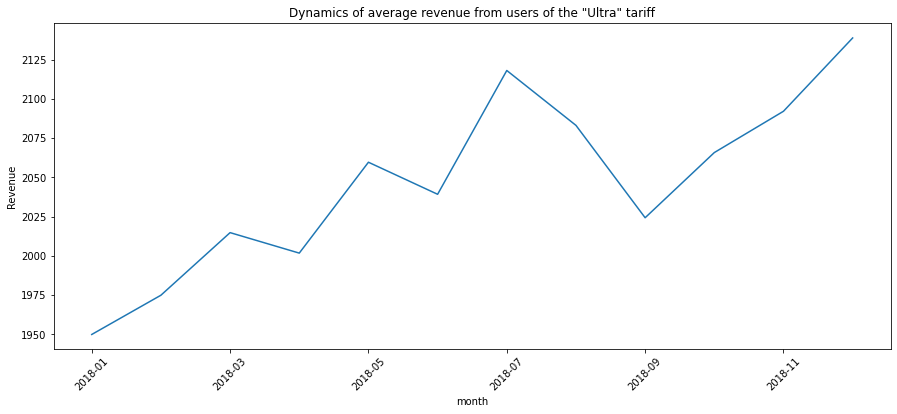

In [ ]:
plt.title('Dynamics of average revenue from users of the "Ultra" tariff')
plt.ylabel('Revenue')
data.query('tariff == "ultra"'
).groupby('month'
)['revenue'].agg('mean'
).plot(x='month', y='revenue', figsize=(15,6), rot=45)
plt.show()

Here you can look at the dynamics of the expenses of the random %username%:

User ID: 1262


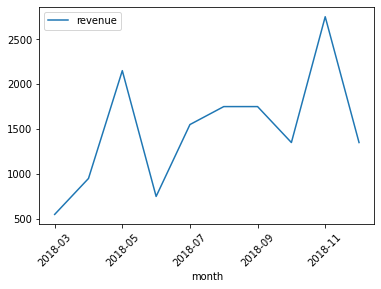

In [ ]:
random_user = np.random.randint(1000,1499)
print(f'User ID: {random_user}')
data.query('user_id == @random_user')[['user_id','revenue','month']].plot(x='month', y='revenue', rot=45)
plt.show()

## Testing statistical hypotheses

###  Hypothesis: The average revenue of users of the Ultra and Smart tariffs differ

Let's check the hypothesis about the difference between the average revenue of users of two tariffs:
    
H0 - the average revenue of users of the "Ultra" and "Smart" tariffs do not differ

H1 - the average revenue of users of the "Ultra" and "Smart" tariffs differ

The critical level of statistical significance will be set by the standard value of 0.05

In [ ]:
st.ttest_ind(users_ultra['revenue'], users_smart['revenue']).pvalue

2.983728825353049e-40

The resulting p-value is significantly less than the given level of statistical significance of 0.05, therefore, the null hypothesis must be rejected, the revenue from users of the two tariffs is different.

###  Hypothesis: The average revenue of users from Moscow differs from the revenue of users from other regions

Let's test the hypothesis about the difference in the average revenue of users in different regions:
    
H0 - the average revenue of users in Moscow and other regions does not differ

H1 - the average revenue of users in Moscow and other regions differ

The critical level of statistical significance will be set by the standard value of 0.05

In [ ]:
data_moscow = data.query('city == "Москва"').groupby('user_id', as_index=False).mean()
data_regions = data.query('city != "Москва"').groupby('user_id', as_index=False).mean()

In [ ]:
st.ttest_ind(data_moscow['revenue'], data_regions['revenue']).pvalue

0.36094633224451433

The resulting p-value is higher than the given level of statistical significance of 0.05, therefore the null hypothesis can be accepted, the revenue from users from Moscow and the regions does not differ.

## Conclusion

As a result of the study, the following was found:
* Users of the "Smart" tariff often spend more traffic than their tariff provides, thus bringing additional revenue to the company.
* Users of the "Ultra" tariff in rare cases consume more services than the tariff, and in general, users do not consume the volume completely, which allows the company to maintain a high level of income by supplying fewer services.
* The "Smart" tariff is more popular among users, the number of its users in the sample is more than twice the number of users of the second tariff.
* The average revenue from users of the two tariffs is different, this difference is statistically significant.
* The average revenue from users from different regions does not differ.

The "Ultra" tariff brings more profit to the operator based on the average revenue per user. At the same time, the dynamics for the year shows that the revenue from users of this tariff fluctuates, while the revenue from users of the second tariff grows more steadily. Therefore, it would be advisable to engage in the promotion of the "Ultra" tariff.
